In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
#sns.set()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import sklearn.linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import sklearn.impute as im
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve


from datetime import timedelta
from datetime import datetime

from tqdm import tqdm

import warnings 
warnings.filterwarnings('ignore')



In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!ls gdrive/MyDrive/'AC297r Capstone QB Group'/Data

Mounted at /content/gdrive
 Aux			       test_counties.csv
'Dataset description.gsheet'   train_counties.csv
 Deprecated		       train_test_key.csv
 Merging.ipynb		       USDM
 NOAA			       USDM_SET_full.csv
'Sentinel Hub'		       USDM_SMAP_SET_9Counties.csv
 SET			       USDM_SMAP_SET_full.csv
 SMAP			       USDM_SMAP_SET_NOAA_full.csv
 smap_fip_tifs		       USDM_SMAP_SET_NOAA_STL_full.csv


In [ ]:
"""
df_full = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/USDM_SMAP_SET_NOAA_STL_full.csv').drop(columns=['Unnamed: 0'])
df_full[df_full == -9999] = np.nan
FIPS = df_full.FIPS.unique()

df_full.head()


df_full['MapDate'] = pd.to_datetime(df_full['MapDate'])

#df_full[]
"""

"\ndf_full = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/USDM_SMAP_SET_NOAA_STL_full.csv').drop(columns=['Unnamed: 0'])\ndf_full[df_full == -9999] = np.nan\nFIPS = df_full.FIPS.unique()\n\ndf_full.head()\n\n\ndf_full['MapDate'] = pd.to_datetime(df_full['MapDate'])\n\n#df_full[]\n"

### Read dataset, split train and test sets


In [4]:
df_full = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/USDM_SMAP_SET_NOAA_full.csv')
df_stl_region = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/USDM_SMAP_SET_NOAA_STL_full.csv')

train_counties, test_counties = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/train_counties.csv'),pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/test_counties.csv')

df_full[df_full == -9999] = np.nan
df_stl_region[df_stl_region == -9999] = np.nan

train_counties.reset_index(inplace = True)
test_counties.reset_index(inplace = True)

df_stl_region['test'] = [1 if fip in test_counties['FIPS'].unique() else 0 for fip in df_stl_region['FIPS']]

df_stl_region = df_stl_region[['NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff', 'Region', 'test']]


df_full = df_full.join(df_stl_region)

df_full['MapDate'] = pd.to_datetime(df_full['MapDate'])

In [5]:
# Preprocess D0 - D4
D4_true = df_full.D4
D3_true = df_full.D3- df_full.D4
D2_true = df_full.D2 - df_full.D3
D1_true = df_full.D1 - df_full.D2
D0_true = df_full.D0 - df_full.D1

df_full['D0']=D0_true
df_full['D1']=D1_true
df_full['D2']=D2_true
df_full['D3']=D3_true
df_full['D4']=D4_true

df_full['D'] = df_full[['None','D0','D1','D2','D3','D4']].apply(lambda x: np.argmax(x.values),axis=1)

In [6]:
df_full

,Unnamed: 0,MapDate,FIPS,County,State,None,D0,D1,D2,D3,...,TMIN,NDVI_1,NDVI_2,NDVI_diff,NDRE_1,NDRE_2,NDRE_diff,Region,test,D
0,1593,2011-12-27,1007,Bibb County,AL,0.00,45.46,54.54,0.00,0.00,...,55.500000,NaN,NaN,NaN,NaN,NaN,NaN,Southeast,0,2
1,1594,2012-01-03,1007,Bibb County,AL,0.00,45.46,54.54,0.00,0.00,...,40.571429,NaN,NaN,NaN,NaN,NaN,NaN,Southeast,0,2
2,1595,2012-01-10,1007,Bibb County,AL,0.00,45.46,54.54,0.00,0.00,...,25.428571,NaN,NaN,NaN,NaN,NaN,NaN,Southeast,0,2
3,1596,2012-01-17,1007,Bibb County,AL,41.41,58.59,0.00,0.00,0.00,...,95.428571,NaN,NaN,NaN,NaN,NaN,NaN,Southeast,0,1
4,1597,2012-01-24,1007,Bibb County,AL,100.00,0.00,0.00,0.00,0.00,...,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,Southeast,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238945,1649812,2022-01-25,56043,Washakie County,WY,0.00,0.00,0.00,100.00,0.00,...,-135.857143,59.769846,63.385346,-5.704000,80.070830,85.601462,-6.460908,NorthernRR,1,3
238946,1649813,2022-02-01,56043,Washakie County,WY,0.00,0.00,0.00,100.00,0.00,...,-153.285714,63.385346,58.522920,8.308584,85.601462,94.392398,-9.313183,NorthernRR,1,3
238947,1649814,2022-02-08,56043,Washakie County,WY,0.00,0.00,0.00,83.25,16.75,...,-88.000000,58.522920,48.684130,20.209440,94.392398,96.972405,-2.660558,NorthernRR,1,3
238948,1649815,2022-02-15,56043,Washakie County,WY,0.00,0.00,0.00,47.61,52.39,...,-88.142857,48.684130,40.099745,21.407581,96.972405,93.996836,3.165605,NorthernRR,1,4


prepare categorical target variables

none = 100 --> 0, otherwise 1


In [7]:
df_full.columns

Index(['Unnamed: 0', 'MapDate', 'FIPS', 'County', 'State', 'None', 'D0', 'D1',
       'D2', 'D3', 'D4', 'ValidStart', 'ValidEnd', 'StatisticFormatID', 'wsum',
       'FIPS STR', 'roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN',
       'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff',
       'Region', 'test', 'D'],
      dtype='object')

In [8]:
df_full['y_cat']=np.where(df_full['None'].to_numpy() ==100,0,1)



In [9]:
# dataframe extract year from date string
temp = pd.to_datetime(df_full['MapDate'],format='%Y%m%d')
df_full['year']= pd.DatetimeIndex(temp).year

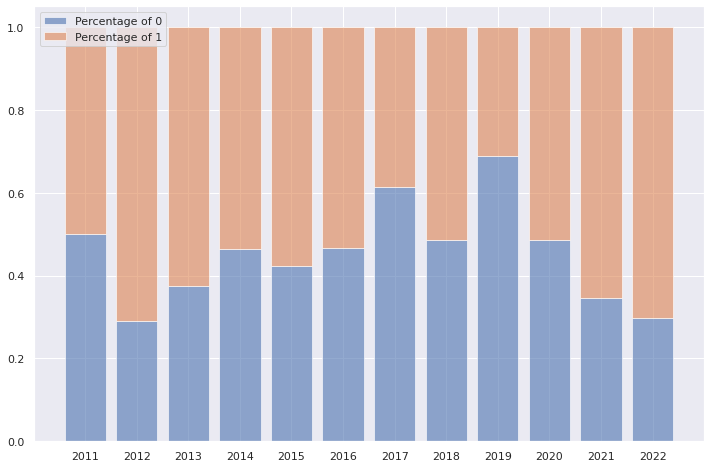

In [ ]:
perc_0 = []
perc_1 = []
year_list = np.unique(df_full.year)
group_count = df_full.groupby(['year','y_cat']).count()[['MapDate']]
for year in year_list:
  freq_0 = group_count.loc[year,0].values[0]
  freq_1 = group_count.loc[year,1].values[0]
  perc_0.append(freq_0/(freq_0+freq_1))
  perc_1.append(freq_1/(freq_0+freq_1))

plt.figure(figsize=(12,8))

plt.bar(year_list ,perc_0,label = 'Percentage of 0',alpha = 0.6)
plt.bar(year_list ,perc_1, label = 'Percentage of 1',alpha = 0.6,bottom= perc_0)
plt.xticks(year_list)
plt.legend(loc = 'upper left')
plt.show()

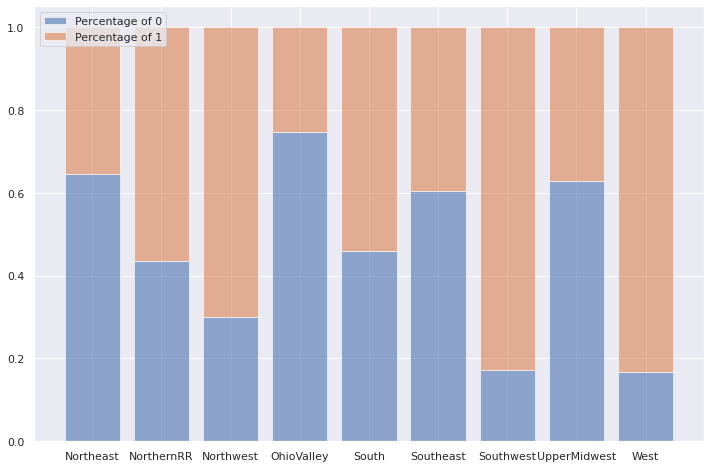

In [ ]:
perc_0 = []
perc_1 = []
region_list = np.unique(df_full.Region)
group_count = df_full.groupby(['Region','y_cat']).count()[['MapDate']]
for region in region_list:
  freq_0 = group_count.loc[region,0].values[0]
  freq_1 = group_count.loc[region,1].values[0]
  perc_0.append(freq_0/(freq_0+freq_1))
  perc_1.append(freq_1/(freq_0+freq_1))


plt.figure(figsize=(12,8))
plt.bar(region_list ,perc_0,label = 'Percentage of 0',alpha = 0.6)
plt.bar(region_list ,perc_1, label = 'Percentage of 1',alpha = 0.6,bottom= perc_0)
plt.legend(loc = 'upper left')
plt.show()

## Examine the feature separation by time. 

挑几个能分得开的feature，然后看看每一年是不是都能分开。

In [ ]:
df_full

,Unnamed: 0,MapDate,FIPS,County,State,None,D0,D1,D2,D3,...,NDVI_2,NDVI_diff,NDRE_1,NDRE_2,NDRE_diff,Region,test,D,y_cat,year
0,1593,2011-12-27,1007,Bibb County,AL,0.00,45.46,54.54,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,Southeast,0,2,1,2011
1,1594,2012-01-03,1007,Bibb County,AL,0.00,45.46,54.54,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,Southeast,0,2,1,2012
2,1595,2012-01-10,1007,Bibb County,AL,0.00,45.46,54.54,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,Southeast,0,2,1,2012
3,1596,2012-01-17,1007,Bibb County,AL,41.41,58.59,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,Southeast,0,1,1,2012
4,1597,2012-01-24,1007,Bibb County,AL,100.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,Southeast,0,0,0,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238945,1649812,2022-01-25,56043,Washakie County,WY,0.00,0.00,0.00,100.00,0.00,...,63.385346,-5.704000,80.070830,85.601462,-6.460908,NorthernRR,1,3,1,2022
238946,1649813,2022-02-01,56043,Washakie County,WY,0.00,0.00,0.00,100.00,0.00,...,58.522920,8.308584,85.601462,94.392398,-9.313183,NorthernRR,1,3,1,2022
238947,1649814,2022-02-08,56043,Washakie County,WY,0.00,0.00,0.00,83.25,16.75,...,48.684130,20.209440,94.392398,96.972405,-2.660558,NorthernRR,1,3,1,2022
238948,1649815,2022-02-15,56043,Washakie County,WY,0.00,0.00,0.00,47.61,52.39,...,40.099745,21.407581,96.972405,93.996836,3.165605,NorthernRR,1,4,1,2022


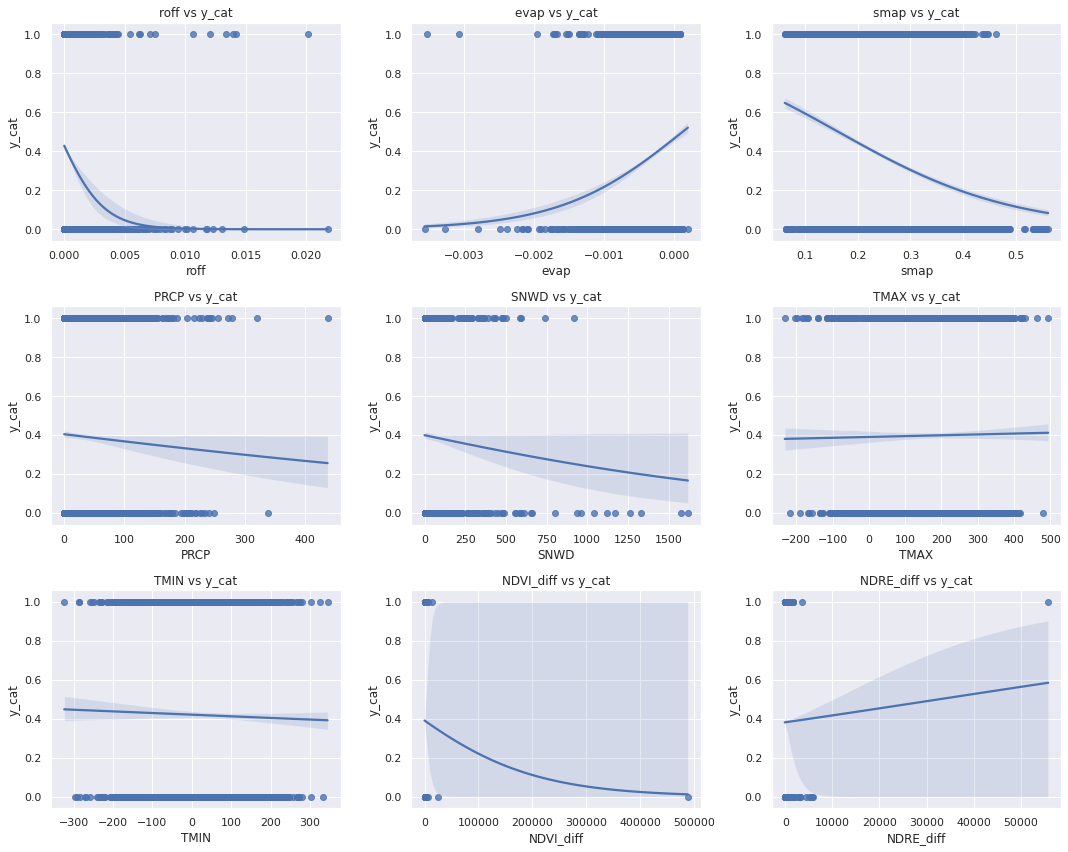

In [ ]:
available_column_list = ['roff','evap','smap','PRCP','SNWD','TMAX','TMIN','NDVI_diff','NDRE_diff']
fig, axs = plt.subplots(3,3, figsize=(15,12))
axs = axs.ravel()
for i in range(9):
  df_temp = df_full[df_full['year'] == 2017].sample(frac = 0.3)
  data = df_temp[[available_column_list[i],'y_cat']].dropna()
  #axs[i].scatter(data[available_column_list[i]],data['y_cat'])

  sns.regplot(x=available_column_list[i], y="y_cat", data=data,truncate = True,logistic=True,ax=axs[i])

  axs[i].set_ylim(-0.06,1.06)   
  axs[i].set_title(f'{available_column_list[i]} vs y_cat')
  plt.tight_layout()

## Logistic Regression (See Michael's for better experiment)

In [10]:
'''
Function below takes following args:
 - model: Sklearn model (e.g. OLS, LinearRegression)
 - X_list: list of predictor labels
 - y_list: list of response labels
 - start_pred: date to begin predicting from formated "YYYY-MM-DD"
 - pred_time: number of weeks after start_pred to predict
 - lag: number of weeks X should be offset to predict Y (default = 1)
 - remove_na: remove NA values from df before modeling (default = True)

Returns:
- fitted model fit to lagged X
- predicted values based on lagged X_test
- MSE based on start_pred and pred_time
'''
# have to change to drop y based on index of X


def build_model(model, df, df_test, X_list, y_list, start_pred, pred_time, start_train = '2012-01-01', lag = 1, remove_na = True, loss = mean_squared_error, flatten = True):


    df = df.sort_values('MapDate')

    df = df.loc[df['MapDate'] >= datetime.strptime(start_train, '%Y-%M-%d')]
    
    X_train = df.loc[df['MapDate'] < datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag), X_list]

    y_train = df.loc[df['MapDate'] >= (min(df['MapDate']) + timedelta(weeks = lag)),:]
    y_train = y_train.loc[y_train['MapDate'] <= start_pred, y_list]


    if (len(df_test) == len(df)):

        df_test = df[df['MapDate'] >= datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag) ]
    
    else:
        df_test = df_test[df_test['MapDate'] >= datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag) ]

    X_test = df_test[df_test['MapDate'] < datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag) + timedelta(weeks = pred_time)][X_list]

    y_test = df_test[df_test['MapDate'] < datetime.strptime(start_pred, '%Y-%M-%d') + timedelta(weeks = pred_time)]
    y_test = y_test[y_test['MapDate'] >= datetime.strptime(start_pred, '%Y-%M-%d')][y_list]

    X_test = X_test.drop('MapDate', axis = 1)


    X_train = X_train.drop('MapDate', axis = 1)

    if remove_na:
        X_train = X_train.dropna()
        y_train = y_train.dropna()
        X_test = X_test.dropna()
        y_test = y_test.dropna()

        
    if flatten:
        fit = model.fit(X_train, y_train.values.flatten())
    else:
        fit = model.fit(X_train, y_train)
    
    
    prediction = model.predict(X_test)

    loss = loss(y_test, prediction)

    return fit, prediction, loss, model, X_test, y_test


def impute(df):
    imp = im.SimpleImputer()
    return imp.fit_transform(df)


In [13]:
# impute data

df_filled = df_full.copy()
df_filled['MapDate'] = (df_full['MapDate'] - df_full['MapDate'].min())  / np.timedelta64(1,'D')


X_list = ['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']
y_list = ['y_cat', 'D0', 'D1', 'D2', 'D3', 'D4']

vars = X_list.copy()
[vars.append(y) for y in y_list]

for fip in tqdm(df_filled['FIPS'].unique()):

    t_var = vars.copy()

    na_ind = np.where(df_filled.loc[df_filled['FIPS'] == fip, vars].isna().sum() == df_filled.loc[df_filled['FIPS'] == fip, vars].shape[0])

    if len(na_ind[0]) > 0:
        [t_var.remove(vars[ind]) for ind in na_ind[0]]

    df_filled.loc[df_filled['FIPS'] == fip, t_var] = df_filled.loc[df_filled['FIPS'] == fip, t_var].mask(df_filled.loc[df_filled['FIPS'] == fip, t_var].isna(), other = lambda x: x.mean(), axis = 1)


# Impute the rest based on national averages, in the future could use regional averages

df_filled[vars] = impute(df_filled[vars])

df_filled = df_filled.rename(columns = {'MapDate' : 'week'})
df_filled['MapDate'] = df_full['MapDate']

df_filled.isna().sum()

100%|██████████| 450/450 [00:23<00:00, 19.15it/s]


Unnamed: 0           0
week                 0
FIPS                 0
County               0
State                0
None                 0
D0                   0
D1                   0
D2                   0
D3                   0
D4                   0
ValidStart           0
ValidEnd             0
StatisticFormatID    0
wsum                 0
FIPS STR             0
roff                 0
evap                 0
smap                 0
PRCP                 0
SNWD                 0
TMAX                 0
TMIN                 0
NDVI_1               0
NDVI_2               0
NDVI_diff            0
NDRE_1               0
NDRE_2               0
NDRE_diff            0
Region               0
test                 0
D                    0
y_cat                0
year                 0
MapDate              0
dtype: int64

In [14]:
df_train = df_filled[df_filled['test'] == 0]
df_test = df_filled[df_filled['test'] == 1]

df_train = df_train.drop(columns=['y_cat'])
df_test = df_test.drop(columns=['y_cat'])

df_train['y_cat']=np.where(df_train['None'].to_numpy() ==100,0,1)
df_test['y_cat']=np.where(df_test['None'].to_numpy() ==100,0,1)

In [15]:
# test runs
start_pred = '2021-01-01'
start_train = ['2012-01-01', '2015-01-01', '2017-01-01','2019-01-01']

X_list = ['MapDate','week', 'roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']
y_list = ['y_cat']

# test run
weeks = [4, 8, 12, 26, 52]
lags = [4, 8, 12, 26, 52]

results = np.zeros((len(lags), len(weeks), len(start_train)))

model = LogisticRegression()

for i, week in tqdm(enumerate(weeks)):
    for j, lag in enumerate(lags):
        for k, start in enumerate(start_train):
            res = build_model(model, df_train, df_test, X_list, y_list, start_pred, week, lag = lag, start_train = start)
            results[i, j, k] = res[2]

results = results.astype(float)

5it [03:08, 37.60s/it]


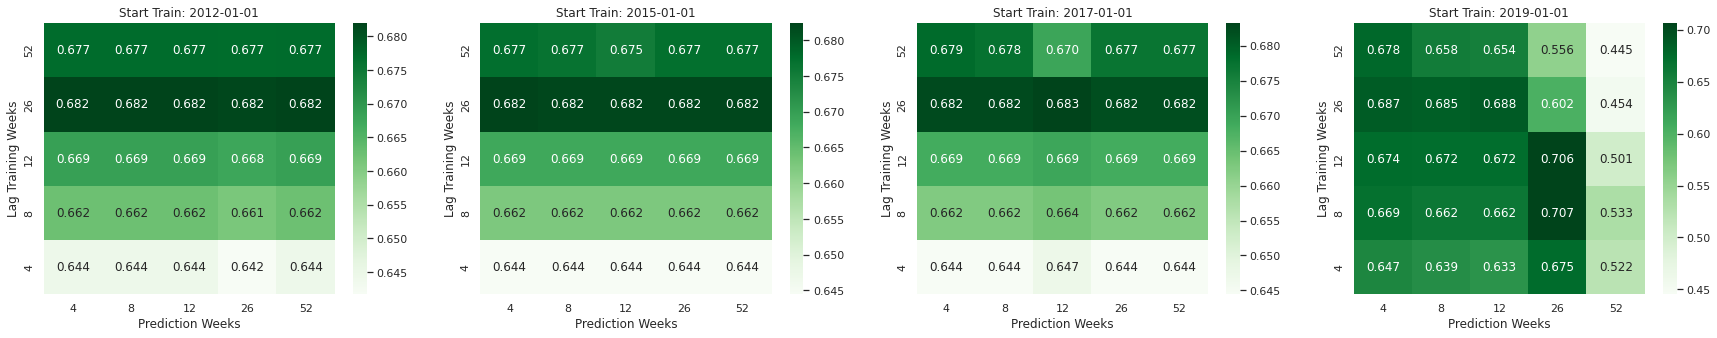

In [16]:
fig, ax = plt.subplots(1,4, figsize = (30,5))

sns.heatmap(results[:,:,0], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[0], xticklabels = weeks, yticklabels=lags)
ax[0].set_title('Start Train: ' + start_train[0])
ax[0].set_xlabel('Prediction Weeks')
ax[0].set_ylabel('Lag Training Weeks')
ax[0].invert_yaxis()

sns.heatmap(results[:,:,1], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[1], xticklabels = weeks, yticklabels=lags)
ax[1].set_title('Start Train: ' + start_train[1])
ax[1].set_xlabel('Prediction Weeks')
ax[1].set_ylabel('Lag Training Weeks')
ax[1].invert_yaxis()

sns.heatmap(results[:,:,2], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[2], xticklabels = weeks, yticklabels=lags)
ax[2].set_title('Start Train: ' + start_train[2])
ax[2].set_xlabel('Prediction Weeks')
ax[2].set_ylabel('Lag Training Weeks')
ax[2].invert_yaxis()

sns.heatmap(results[:,:,3], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[3], xticklabels = weeks, yticklabels=lags)
ax[3].set_title('Start Train: ' + start_train[3])
ax[3].set_xlabel('Prediction Weeks')
ax[3].set_ylabel('Lag Training Weeks')
ax[3].invert_yaxis()

plt.show()

## Decision Tree

### Decision Tree 5 Cat

In [17]:
results = np.zeros((len(lags), len(weeks), len(start_train)))

model_DT = DecisionTreeClassifier(max_depth = 10)



for i, week in tqdm(enumerate(weeks)):
    for j, lag in enumerate(lags):
        for k, start in enumerate(start_train):
            res = build_model(model_DT, df_train, df_test, X_list, y_list, start_pred, week, lag = lag, start_train = start,flatten=False)
            results[i, j, k] = res[2]

results = results.astype(float)

5it [02:36, 31.35s/it]


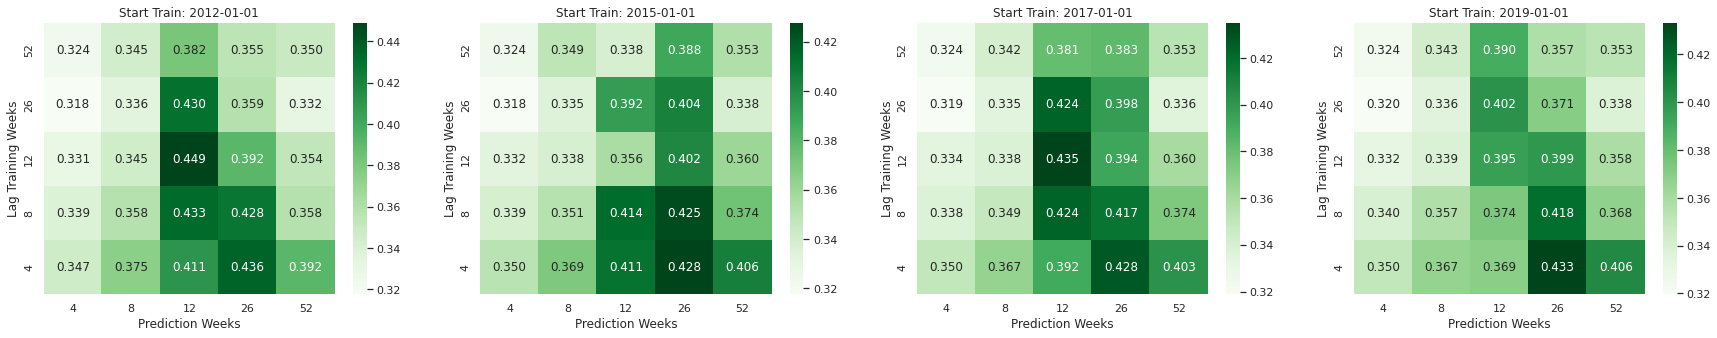

In [18]:
fig, ax = plt.subplots(1,4, figsize = (30,5))

sns.heatmap(results[:,:,0], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[0], xticklabels = weeks, yticklabels=lags)
ax[0].set_title('Start Train: ' + start_train[0])
ax[0].set_xlabel('Prediction Weeks')
ax[0].set_ylabel('Lag Training Weeks')
ax[0].invert_yaxis()

sns.heatmap(results[:,:,1], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[1], xticklabels = weeks, yticklabels=lags)
ax[1].set_title('Start Train: ' + start_train[1])
ax[1].set_xlabel('Prediction Weeks')
ax[1].set_ylabel('Lag Training Weeks')
ax[1].invert_yaxis()

sns.heatmap(results[:,:,2], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[2], xticklabels = weeks, yticklabels=lags)
ax[2].set_title('Start Train: ' + start_train[2])
ax[2].set_xlabel('Prediction Weeks')
ax[2].set_ylabel('Lag Training Weeks')
ax[2].invert_yaxis()

sns.heatmap(results[:,:,3], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[3], xticklabels = weeks, yticklabels=lags)
ax[3].set_title('Start Train: ' + start_train[3])
ax[3].set_xlabel('Prediction Weeks')
ax[3].set_ylabel('Lag Training Weeks')
ax[3].invert_yaxis()

plt.show()

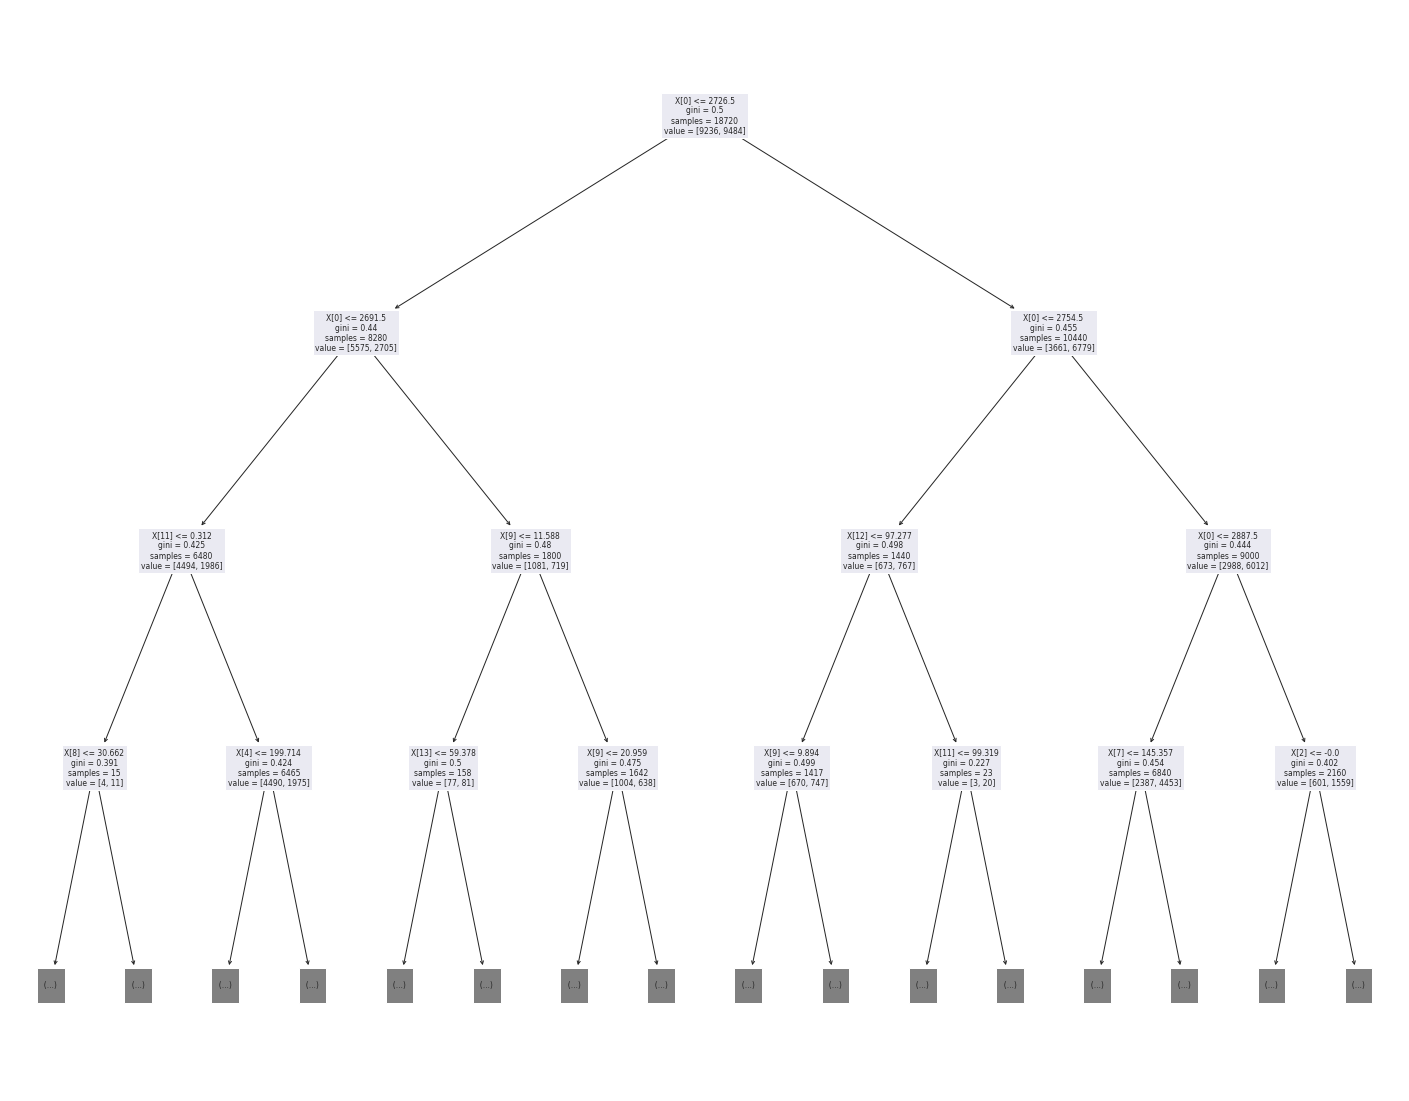

In [19]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_DT,max_depth=3)
plt.show()

In [ ]:
X_list

['MapDate',
 'week',
 'roff',
 'evap',
 'smap',
 'PRCP',
 'SNWD',
 'TMAX',
 'TMIN',
 'NDVI_1',
 'NDVI_2',
 'NDVI_diff',
 'NDRE_1',
 'NDRE_2',
 'NDRE_diff']

### DT 2 Cat

In [35]:
results = np.zeros((len(lags), len(weeks), len(start_train)))

model_DT = DecisionTreeClassifier(max_depth = 10)

y_list = ['y_cat']

X_list = ['MapDate', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN']


for i, week in tqdm(enumerate(weeks)):
    for j, lag in enumerate(lags):
        for k, start in enumerate(start_train):
            res = build_model(model_DT, df_train, df_test, X_list, y_list, start_pred, week, lag = lag, start_train = start,flatten=False)
            results[i, j, k] = res[2]

results = results.astype(float)

5it [01:13, 14.71s/it]


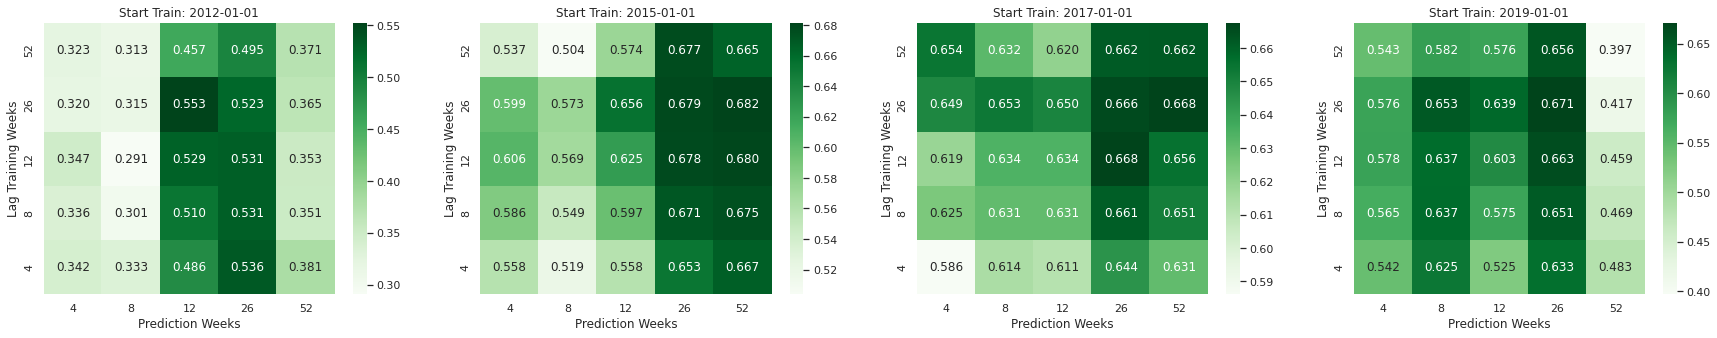

In [37]:
fig, ax = plt.subplots(1,4, figsize = (30,5))

sns.heatmap(results[:,:,0], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[0], xticklabels = weeks, yticklabels=lags)
ax[0].set_title('Start Train: ' + start_train[0])
ax[0].set_xlabel('Prediction Weeks')
ax[0].set_ylabel('Lag Training Weeks')
ax[0].invert_yaxis()

sns.heatmap(results[:,:,1], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[1], xticklabels = weeks, yticklabels=lags)
ax[1].set_title('Start Train: ' + start_train[1])
ax[1].set_xlabel('Prediction Weeks')
ax[1].set_ylabel('Lag Training Weeks')
ax[1].invert_yaxis()

sns.heatmap(results[:,:,2], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[2], xticklabels = weeks, yticklabels=lags)
ax[2].set_title('Start Train: ' + start_train[2])
ax[2].set_xlabel('Prediction Weeks')
ax[2].set_ylabel('Lag Training Weeks')
ax[2].invert_yaxis()

sns.heatmap(results[:,:,3], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[3], xticklabels = weeks, yticklabels=lags)
ax[3].set_title('Start Train: ' + start_train[3])
ax[3].set_xlabel('Prediction Weeks')
ax[3].set_ylabel('Lag Training Weeks')
ax[3].invert_yaxis()

plt.show()

# Fit a RandomForestClassifier using the same tree depth.

In [22]:
df_train_down = df_train[df_train.Region == 'Southeast']
df_test_down = df_test[df_test.Region == 'Southeast']

In [41]:

results = np.zeros((len(lags), len(weeks), len(start_train)))

model_RF = RandomForestClassifier(random_state=42 , max_depth = 10)


for i, week in tqdm(enumerate(weeks)):
    for j, lag in enumerate(lags):
        for k, start in enumerate(start_train):
            res = build_model(model_RF, df_train, df_test, X_list, y_list, start_pred, week, lag = lag, start_train = start)
            results[i, j, k] = res[2]


results = results.astype(float)

5it [18:34, 222.97s/it]


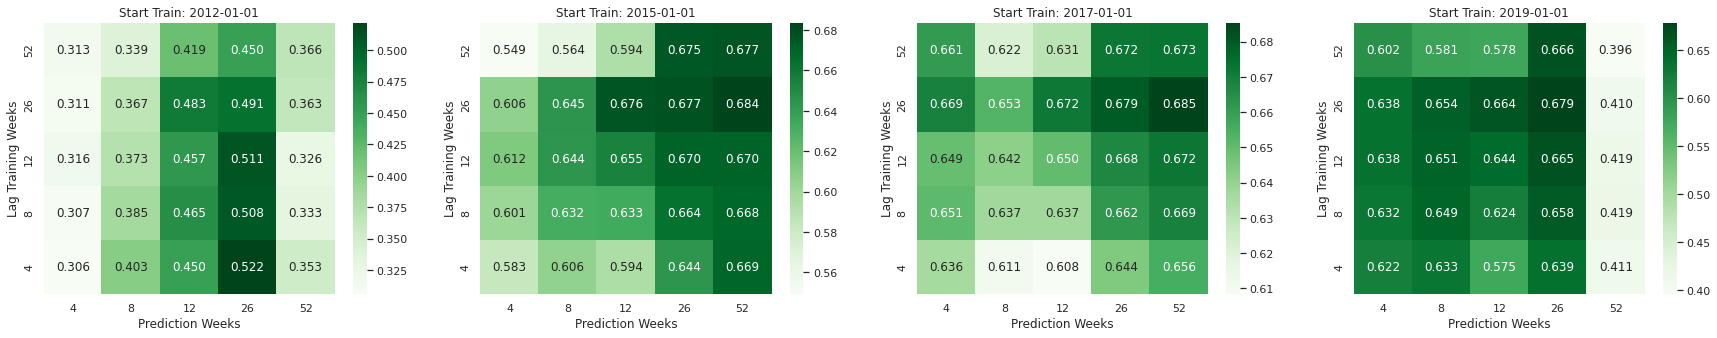

In [42]:
fig, ax = plt.subplots(1,4, figsize = (30,5))

sns.heatmap(results[:,:,0], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[0], xticklabels = weeks, yticklabels=lags)
ax[0].set_title('Start Train: ' + start_train[0])
ax[0].set_xlabel('Prediction Weeks')
ax[0].set_ylabel('Lag Training Weeks')
ax[0].invert_yaxis()

sns.heatmap(results[:,:,1], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[1], xticklabels = weeks, yticklabels=lags)
ax[1].set_title('Start Train: ' + start_train[1])
ax[1].set_xlabel('Prediction Weeks')
ax[1].set_ylabel('Lag Training Weeks')
ax[1].invert_yaxis()

sns.heatmap(results[:,:,2], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[2], xticklabels = weeks, yticklabels=lags)
ax[2].set_title('Start Train: ' + start_train[2])
ax[2].set_xlabel('Prediction Weeks')
ax[2].set_ylabel('Lag Training Weeks')
ax[2].invert_yaxis()

sns.heatmap(results[:,:,3], annot = True, cmap = 'Greens', fmt='.3f', ax = ax[3], xticklabels = weeks, yticklabels=lags)
ax[3].set_title('Start Train: ' + start_train[3])
ax[3].set_xlabel('Prediction Weeks')
ax[3].set_ylabel('Lag Training Weeks')
ax[3].invert_yaxis()

plt.show()

In [ ]:
def build_model(model, df, df_test, X_list, y_list, start_pred, pred_time, start_train = '2012-01-01', lag = 1, remove_na = True, loss = mean_squared_error, flatten = True):


    df = df.sort_values('MapDate')

    df = df.loc[df['MapDate'] >= datetime.strptime(start_train, '%Y-%M-%d')]
    
    X_train = df.loc[df['MapDate'] < datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag), X_list]

    y_train = df.loc[df['MapDate'] >= (min(df['MapDate']) + timedelta(weeks = lag)),:]
    y_train = y_train.loc[y_train['MapDate'] <= start_pred, y_list]


    if (len(df_test) == len(df)):

        df_test = df[df['MapDate'] >= datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag) ]
    
    else:
        df_test = df_test[df_test['MapDate'] >= datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag) ]

    X_test = df_test[df_test['MapDate'] < datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag) + timedelta(weeks = pred_time)][X_list]

    y_test = df_test[df_test['MapDate'] < datetime.strptime(start_pred, '%Y-%M-%d') + timedelta(weeks = pred_time)]
    y_test = y_test[y_test['MapDate'] >= datetime.strptime(start_pred, '%Y-%M-%d')][y_list]

    X_test = X_test.drop('MapDate', axis = 1)


    X_train = X_train.drop('MapDate', axis = 1)

    if remove_na:
        X_train = X_train.dropna()
        y_train = y_train.dropna()
        X_test = X_test.dropna()
        y_test = y_test.dropna()

        
    if flatten:
        fit = model.fit(X_train, y_train.values.flatten())
    else:
        fit = model.fit(X_train, y_train)
    
    
    prediction = model.predict(X_test)

    loss = loss(y_test, prediction)

    return fit, prediction, loss, model, X_test, y_test

No Skill: ROC AUC=0.500
RF: ROC AUC=0.642


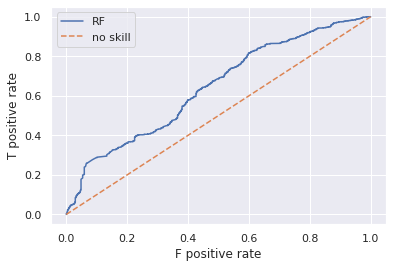

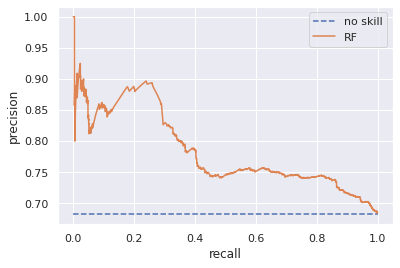

In [39]:
# Best model seems to include lag of 8 predicing 26 weeks

df_train_copy = df_train.copy()
df_test_copy = df_test.copy()


thresh = 0.9
week = 26
lag = 8
start = '2012-01-01'

X_list = ['MapDate', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN']
y_list = ['y_cat']

model = RandomForestClassifier(random_state=42 , max_depth = 8)
start_pred = '2021-01-01'

df_train_copy[y_list] = (df_train[y_list].values >= thresh).astype(int)
df_test_copy[y_list] = (df_test[y_list].values >= thresh).astype(int)

res = build_model(model, df_train_copy, df_test_copy, X_list, y_list, start_pred, pred_time = week, lag = lag, start_train = start, loss = accuracy_score)

lr_fpr, lr_tpr, _ = roc_curve(res[5], res[0].predict_proba(res[4])[:,1])
ns_fpr, ns_tpr, _ = roc_curve(res[5], np.ones(len(res[5])))

# calculate scores
ns_auc = roc_auc_score(res[5], np.ones(len(res[5])))
lr_auc = roc_auc_score(res[5], res[0].predict_proba(res[4])[:,1])
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RF: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
plt.plot(lr_fpr, lr_tpr, label = 'RF')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label = 'no skill')
plt.legend()
plt.xlabel('F positive rate')
plt.ylabel('T positive rate')
plt.show()

# Precision-Recall curve
lr_precision, lr_recall, _ = precision_recall_curve(res[5], res[0].predict_proba(res[4])[:,1])
ns = res[5][res[5]==1].sum() / len(res[5])
plt.plot([0, 1], [ns, ns], linestyle='--', label='no skill')
plt.plot(lr_recall, lr_precision, label='RF')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()

No Skill: ROC AUC=0.500
DT: ROC AUC=0.632


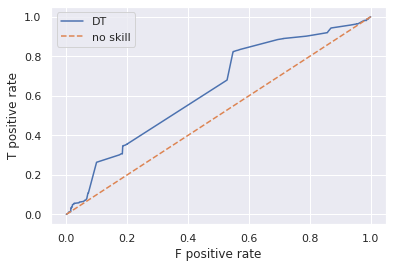

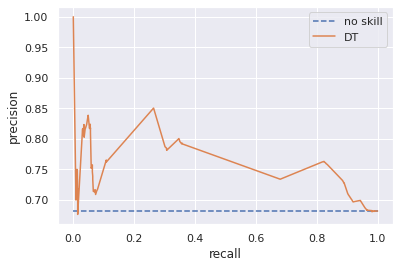

In [34]:
# Best model seems to include lag of 8 predicing 26 weeks

df_train_copy = df_train.copy()
df_test_copy = df_test.copy()


thresh = 0.9
week = 26
lag = 8
start = '2017-01-01'

X_list = ['MapDate', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN']
y_list = ['y_cat']

model = DecisionTreeClassifier(max_depth = 10)
start_pred = '2021-01-01'

df_train_copy[y_list] = (df_train[y_list].values >= thresh).astype(int)
df_test_copy[y_list] = (df_test[y_list].values >= thresh).astype(int)

res = build_model(model, df_train_copy, df_test_copy, X_list, y_list, start_pred, pred_time = week, lag = lag, start_train = start, loss = accuracy_score)

lr_fpr, lr_tpr, _ = roc_curve(res[5], res[0].predict_proba(res[4])[:,1])
ns_fpr, ns_tpr, _ = roc_curve(res[5], np.ones(len(res[5])))

# calculate scores
ns_auc = roc_auc_score(res[5], np.ones(len(res[5])))
lr_auc = roc_auc_score(res[5], res[0].predict_proba(res[4])[:,1])
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('DT: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
plt.plot(lr_fpr, lr_tpr, label = 'DT')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label = 'no skill')
plt.legend()
plt.xlabel('F positive rate')
plt.ylabel('T positive rate')
plt.show()

# Precision-Recall curve
lr_precision, lr_recall, _ = precision_recall_curve(res[5], res[0].predict_proba(res[4])[:,1])
ns = res[5][res[5]==1].sum() / len(res[5])
plt.plot([0, 1], [ns, ns], linestyle='--', label='no skill')
plt.plot(lr_recall, lr_precision, label='DT')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()

### Using Jim's TRTE split

In [ ]:
ttkey=pd.read_csv('train_test_key.csv',dtype=str)
trkey=ttkey.iloc[:,0]
trkey=[int(i) for i in list(trkey.to_numpy())]
tekey=ttkey.iloc[:,2].dropna(axis=0)
tekey=[int(i) for i in list(tekey.to_numpy())]

## Old DT

In [46]:
# Build a decision tree model

df_train = df_filled[df_filled['test'] == 0]
df_test = df_filled[df_filled['test'] == 1]


X_train = df_train[['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']]
X_test = df_test[['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']]





y_train = df_train['y_cat'].values
y_test = df_test['y_cat'].values

#X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)  

depth_list = np.arange(10,20)

cvmeans = []
cvstds = []
train_scores  =[]
for d in depth_list:
    # Fit a decision tree to the entire training set.
    tree = DecisionTreeClassifier(max_depth = d)
    tree.fit(X_train, y_train)
    # Evaluate on the entire training set
    train_scores.append(tree.score(X_train, y_train))
    # Perform 5-fold cross-validation with the entire training set,
    cv_score = cross_val_score(tree, X_train, y_train,cv = 5)
    cvmeans.append(cv_score.mean())
    cvstds.append(cv_score.std())

train_scores  = np.array(train_scores)
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

In [ ]:
y_train

array([2, 2, 2, ..., 3, 3, 3])

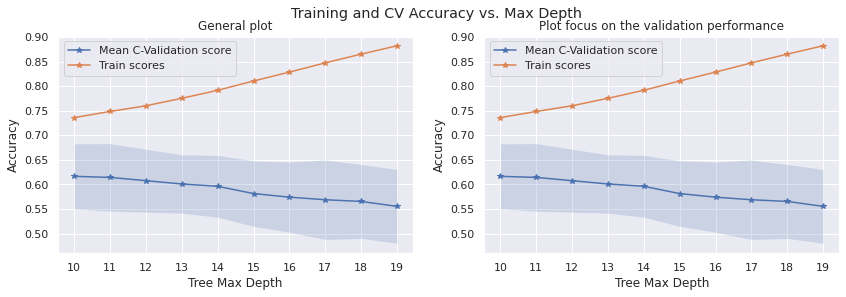

In [47]:
# Set up the plot
fig, axs = plt.subplots(1,2, figsize=(14, 4))
fig.suptitle("Training and CV Accuracy vs. Max Depth")

axs[0].plot(depth_list, cvmeans, '-*', label="Mean C-Validation score")
axs[0].plot(depth_list, train_scores, '-*', label="Train scores")
axs[0].fill_between(depth_list, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.2)
axs[0].set_title("General plot")
axs[0].set_xlabel("Tree Max Depth")
axs[0].set_xticks(depth_list)
axs[0].set_ylabel("Accuracy")
#axs[0].set_ylim(0.5,0.6)
axs[0].legend()

axs[1].plot(depth_list, cvmeans, '-*', label="Mean C-Validation score")
axs[1].plot(depth_list, train_scores, '-*', label="Train scores")
axs[1].fill_between(depth_list, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.2)
axs[1].set_title("Plot focus on the validation performance")
axs[1].set_xlabel("Tree Max Depth")
axs[1].set_xticks(depth_list)
axs[1].set_ylabel("Accuracy")
#axs[1].set_ylim(0.55,0.6)
axs[1].legend()

plt.show()

Feature: 0, Score: 0.23711
Feature: 1, Score: 0.10181
Feature: 2, Score: 0.16543
Feature: 3, Score: 0.04513
Feature: 4, Score: 0.03144
Feature: 5, Score: 0.06116
Feature: 6, Score: 0.06527
Feature: 7, Score: 0.04025
Feature: 8, Score: 0.04066
Feature: 9, Score: 0.04956
Feature: 10, Score: 0.04897
Feature: 11, Score: 0.05253
Feature: 12, Score: 0.06067


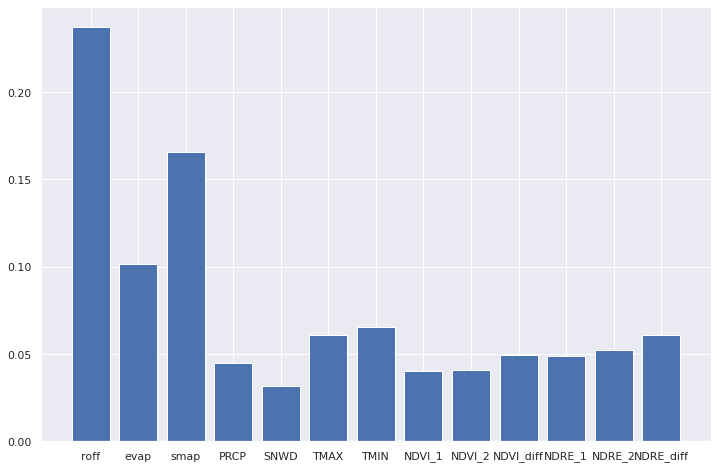

In [48]:
importance = tree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize = (12,8))
plt.bar(X_train.columns, importance)
plt.show()

In [ ]:
import dtreeviz.trees

Experimenting with three dimensions:

1. number of weeks and number of lags used

2. number of features included

3. the starting point

In [ ]:
y_list

['y_cat']

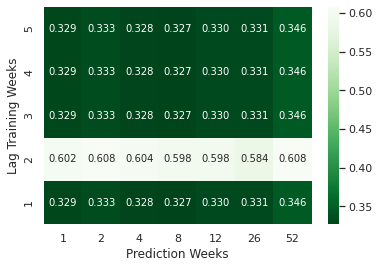

In [ ]:
# test runs
weeks = [1, 2, 4, 8, 12, 26, 52]
lags = [1, 2, 3, 4, 5]

results = pd.DataFrame(index = lags, columns = weeks)

model = LogisticRegression()

df_test = df_filled

for week in weeks:
    for lag in lags:
        res = build_model(model, df_test, X_list, y_list[0], start_pred, week, lag = lag)
        results.loc[lag, week] = res[2]

results = results.astype(float)
ax  = sns.heatmap(results, annot = True, cmap = 'Greens_r', fmt='.3f')
ax.set_xlabel('Prediction Weeks')
ax.set_ylabel('Lag Training Weeks')
ax.invert_yaxis()
plt.show()

In [ ]:
results

,1,2,4,8,12,26
1,0.728889,0.730000,0.708333,0.696667,0.688889,0.637607
2,0.737778,0.735556,0.714444,0.701667,0.694074,0.650085
3,0.728889,0.730000,0.708333,0.696667,0.688889,0.637607
4,0.728889,0.730000,0.708333,0.696667,0.688889,0.637607
5,0.720000,0.717778,0.707222,0.701111,0.692778,0.644274


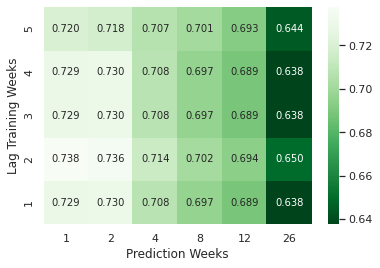

In [ ]:
# test run
weeks = [1,2,4, 8, 12, 26]
lags = [1, 2, 3, 4, 5]

results = pd.DataFrame(index = lags, columns = weeks)

model = LogisticRegression()

df_test = df_filled

start_pred = '2020-01-01' # start time push back


for week in weeks:
    for lag in lags:
        res = build_model(model, df_test, X_list, y_list[0], start_pred, week, lag = lag, loss = accuracy_score)
        results.loc[lag, week] = res[2]

results = results.astype(float)
ax  = sns.heatmap(results, annot = True, cmap = 'Greens_r', fmt='.3f')
ax.set_xlabel('Prediction Weeks')
ax.set_ylabel('Lag Training Weeks')
ax.invert_yaxis()
plt.show()


In [ ]:
results

,1,2,4,8,12,26
1,0.728889,0.730000,0.708333,0.696667,0.688889,0.637607
2,0.737778,0.735556,0.714444,0.701667,0.694074,0.650085
3,0.728889,0.730000,0.708333,0.696667,0.688889,0.637607
4,0.728889,0.730000,0.708333,0.696667,0.688889,0.637607
5,0.720000,0.717778,0.707222,0.701111,0.692778,0.644274


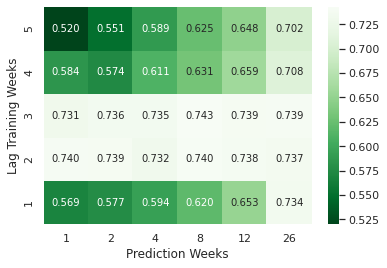

In [ ]:
# test run
weeks = [1,2,4, 8, 12, 26]
lags = [1, 2, 3, 4, 5]

results = pd.DataFrame(index = lags, columns = weeks)

model = LogisticRegression()

df_test = df_filled

start_pred = '2019-01-01' # start time push back


for week in weeks:
    for lag in lags:
        res = build_model(model, df_test, X_list, y_list[0], start_pred, week, lag = lag, loss = accuracy_score)
        results.loc[lag, week] = res[2]

results = results.astype(float)
ax  = sns.heatmap(results, annot = True, cmap = 'Greens_r', fmt='.3f')
ax.set_xlabel('Prediction Weeks')
ax.set_ylabel('Lag Training Weeks')
ax.invert_yaxis()
plt.show()

## Old EDA of a single county or group of counties

In [ ]:
# OLD EDA JUST FOR FUN

dates = pd.to_datetime(df_full[df_full['FIPS'] == FIPS[0]]['MapDate'])

fig,ax = plt.subplots(figsize=(10,10))

ln1 = ax.plot(dates, df_full[df_full['FIPS'] == FIPS[0]]['smap'], color = 'b', alpha = 0.5, label = 'SMAP')
ax.set_xlabel("measurement week")
ax.set_ylabel("smap")
ax.xaxis_date()

date_form = DateFormatter('%d-%m-%y')
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=30))

ax2=ax.twinx()
ln2 = ax2.plot(dates, df_full[df_full['FIPS'] == FIPS[0]]['roff'], color = 'r', alpha = 0.5, label = 'RunOff')
ln3 = ax2.plot(dates, df_full[df_full['FIPS'] == FIPS[0]]['evap'], color = 'g', alpha = 0.5, label = 'Evap')
ax2.set_ylabel("inches of roff or evap")

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


fig.autofmt_xdate()

plt.show()

# New Section

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.134
Model:                            OLS   Adj. R-squared (uncentered):              0.126
Method:                 Least Squares   F-statistic:                              17.98
Date:                Tue, 29 Mar 2022   Prob (F-statistic):                    7.09e-11
Time:                        14:18:37   Log-Likelihood:                         -2400.4
No. Observations:                 353   AIC:                                      4807.
Df Residuals:                     350   BIC:                                      4818.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

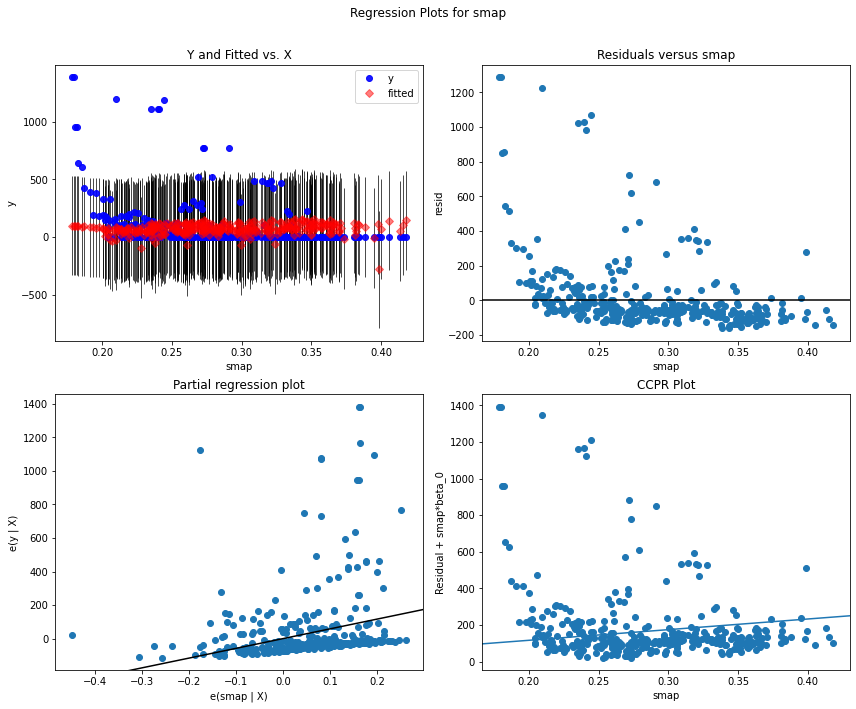

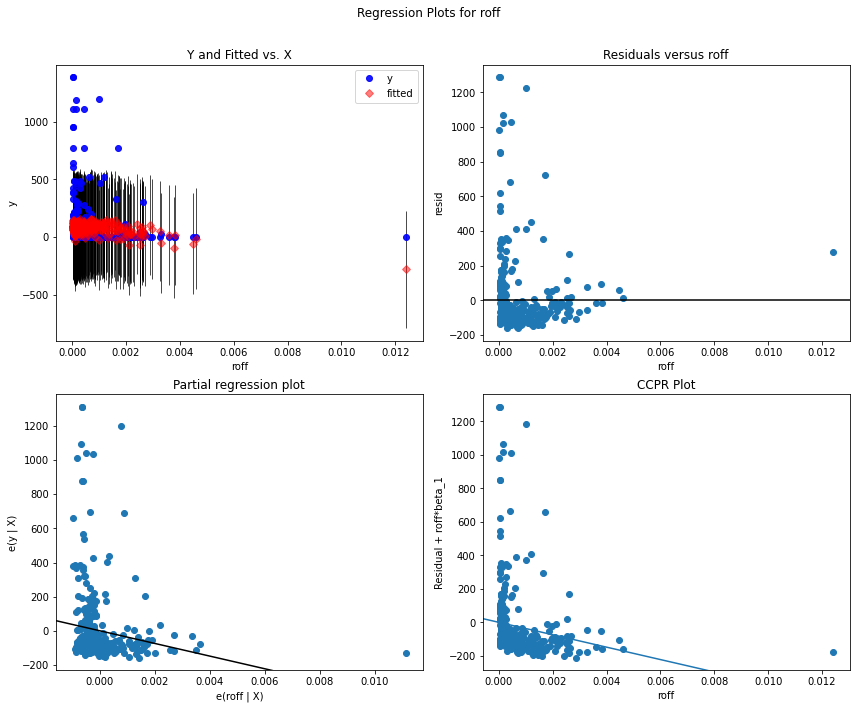

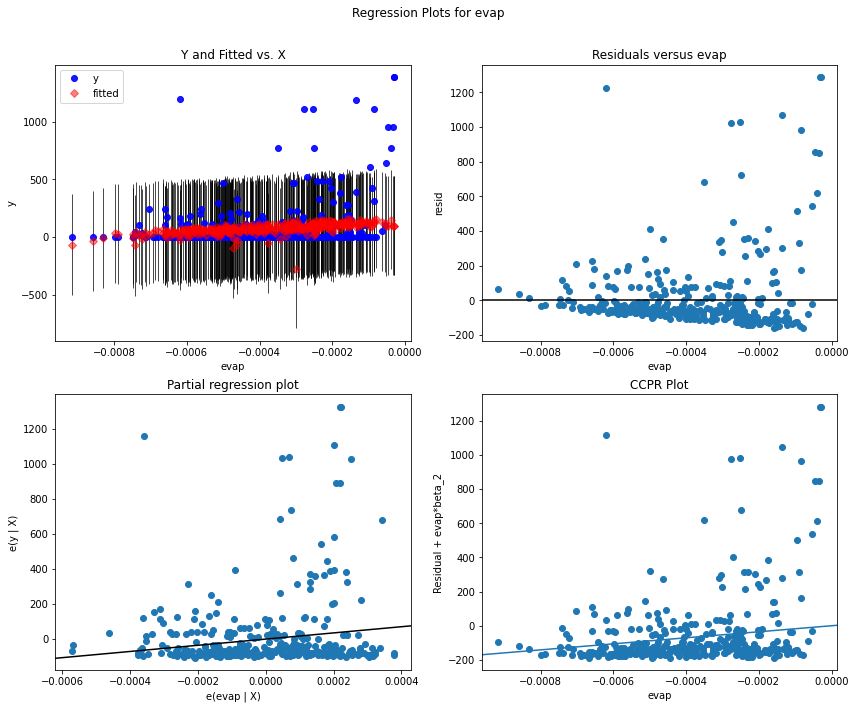

<Figure size 864x720 with 0 Axes>

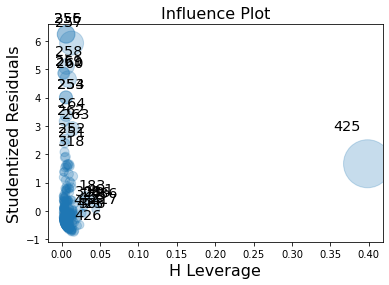

In [ ]:
#sample FIPS[0]

df_fips_0 = df_full[df_full['FIPS'] == FIPS[0]]
       
X_col = ['smap', 'roff', 'evap']
y_col = 'wsum'

X = df_fips_0[X_col]
y = np.array(df_fips_0[y_col]).reshape(-1,1)


lm = sm.OLS(y, X, missing = 'drop')
results = lm.fit()
print(results.summary())

fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 0, fig = fig)
plt.show()
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 1, fig = fig)
plt.show()
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 2, fig = fig)
plt.show()

fig = plt.figure(figsize=(12,10))
sm.graphics.influence_plot(results, fig = fig, plot_alpha=.25)
plt.show()





                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.173
Model:                            OLS   Adj. R-squared (uncentered):              0.166
Method:                 Least Squares   F-statistic:                              24.49
Date:                Tue, 29 Mar 2022   Prob (F-statistic):                    2.09e-14
Time:                        14:18:46   Log-Likelihood:                         -521.39
No. Observations:                 353   AIC:                                      1049.
Df Residuals:                     350   BIC:                                      1060.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

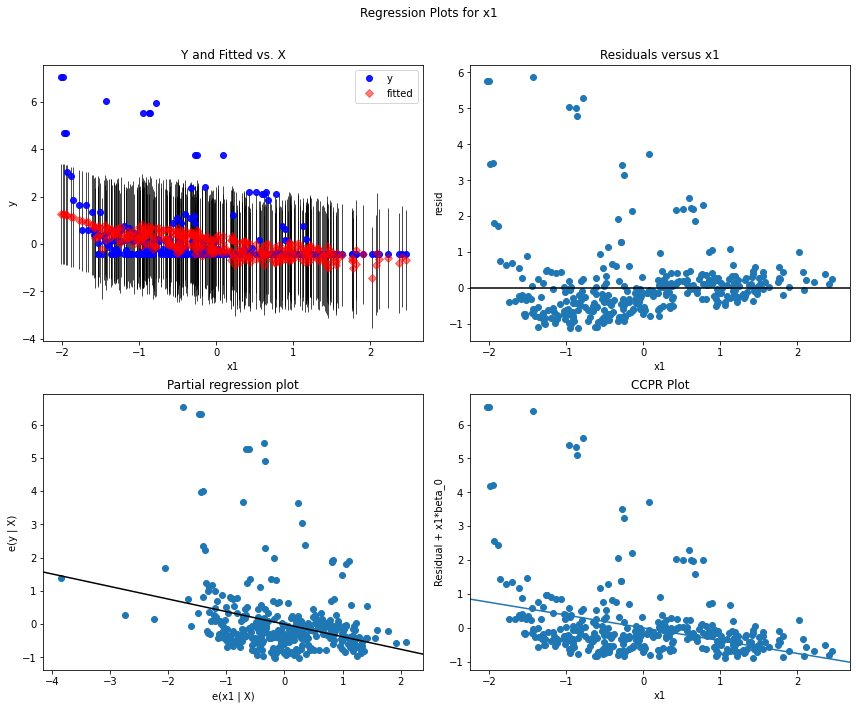

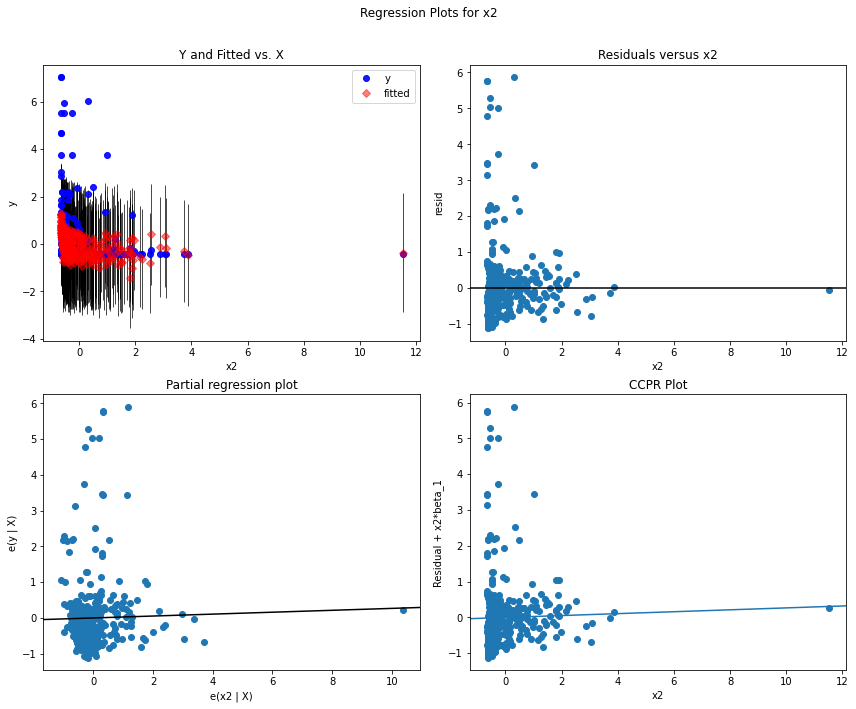

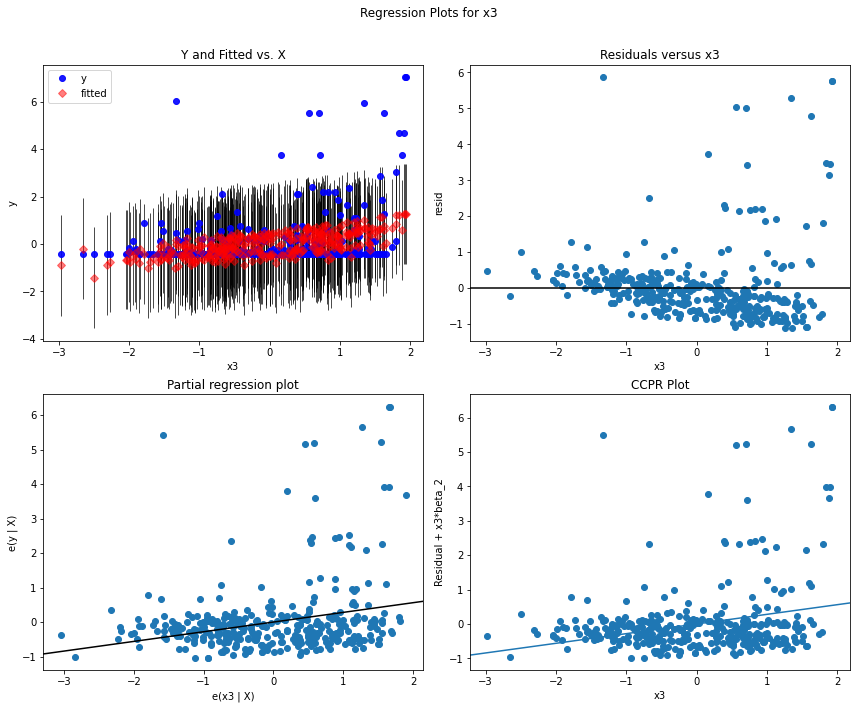

In [ ]:
#sample FIPS[0]

df_fips_0 = df_full[df_full['FIPS'] == FIPS[0]]
       
X_col = ['smap', 'roff', 'evap']
y_col = 'wsum'

X = df_fips_0[X_col]
y = np.array(df_fips_0[y_col]).reshape(-1,1)

scaler = StandardScaler()

X = scaler.fit_transform(X)

y = scaler.fit_transform(y)

lm = sm.OLS(y, X, missing = 'drop')
results = lm.fit()
print(results.summary())

fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 0, fig = fig)
plt.show()
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 1, fig = fig)
plt.show()
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 2, fig = fig)
plt.show()



<Figure size 864x720 with 0 Axes>

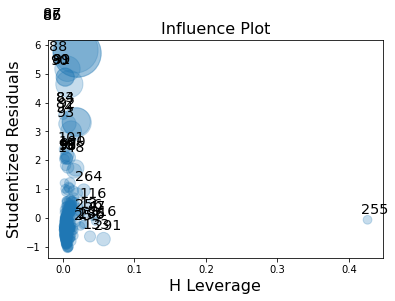

In [ ]:
# fig = plt.figure(figsize=(12,10))
# sm.graphics.plot_partregress_grid(results, fig = fig)
# plt.show()

fig = plt.figure(figsize=(12,10))
sm.graphics.influence_plot(results, fig = fig, plot_alpha=.25)
plt.show()
